# Keras kullanarak resim tanıma ve davranışsal modelleme

Davranışsal modelleme, insanların verilere göre verdiği kararların taklit edilmesine denir. Bu demoda, minyatür bir aracın kamera ve sürüş verilerini kullanarak bir derin yapay sinir ağı eğiteceğiz.

## Verilerin Alınması

Üzerinde çalışacağımız resimler ve bunlara bağlı veriler, Google Drive'da bulunuyor. PyDrive kütüphanesini kullanarak bu resimleri ve verileri işlem yapacağımız ortama aktarıyoruz.

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
data_folder_id = "1h6SETysphwHJU94A8PgzKTDKBXz0xDi2"

datafile_list = drive.ListFile({'q': "'" + data_folder_id + "' in parents and trashed=false"}).GetList();

for image_info in datafile_list:
  print("downloading: " + image_info.metadata["originalFilename"])

  (drive.CreateFile({"id": image_info.metadata["id"]})).GetContentFile(image_info.metadata["originalFilename"])
 

downloading: 00332.jpg
downloading: 00330.jpg
downloading: 00323.jpg
downloading: 00257.jpg
downloading: 00012.jpg
downloading: 00440.jpg
downloading: 00113.jpg
downloading: 00129.jpg
downloading: 00562.jpg
downloading: 00273.jpg
downloading: 00434.jpg
downloading: 00116.jpg
downloading: 00027.jpg
downloading: 00538.jpg
downloading: 00386.jpg
downloading: 00380.jpg
downloading: 00146.jpg
downloading: 00390.jpg
downloading: 00183.jpg
downloading: 00397.jpg
downloading: 00143.jpg
downloading: 00142.jpg
downloading: 00042.jpg
downloading: 00068.jpg
downloading: 00140.jpg
downloading: 00017.jpg
downloading: 00487.jpg
downloading: 00242.jpg
downloading: 00416.jpg
downloading: 00549.jpg
downloading: 00197.jpg
downloading: 00260.jpg
downloading: 00144.jpg
downloading: 00449.jpg
downloading: 00025.jpg
downloading: 00066.jpg
downloading: 00076.jpg
downloading: 00516.jpg
downloading: 00454.jpg
downloading: 00220.jpg
downloading: 00299.jpg
downloading: 00157.jpg
downloading: 00059.jpg
downloading

In [0]:
labelfile_id = "1SzDvNpQOvGvZSyrglHjhzA5eCbSf-qGm"

label_file = drive.CreateFile({'id': labelfile_id})
label_file.GetContentFile("labels.npy")

## Veri setlerinin hazırlanması

Veri setlerini hazırlarken, resimleri okumak için OpenCV, veriyi incelemek için Matplotlib, ayırmak için Numpy kullanılacak

Label dosyasından gelen verilerde üç sütun var:


1.   Resim dosyası ismi
1.   Gidiş hızı
1.   Dönüş açısı

Biz dönüş açısını etiket olarak kullanacağız



In [0]:
import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np

import cv2 as cv

In [0]:
# Numpy'yi kullanarak etiket dosyasını oku
labels = np.load("labels.npy")

# etiketlerin ilk satırını sil: ilk satır boş.
labels = labels[1:]

In [0]:
# labels[:10]

[b'00006.jpg' b'0.198195517063' b'0.0']


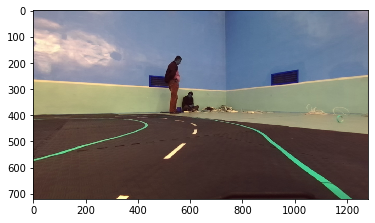

In [0]:
print(labels[0])
first_image = (cv.imread(labels[0][0].decode()))
plt.imshow(first_image)

In [0]:
train_images = []
train_labels = []

test_images = []
test_labels = []

for i in range(len(labels)):
  if i%5 == 0:
    # resimler beçte biri test olarak kullanılacak
    test_labels.append(float(labels[i][2].decode()))
    test_images.append(cv.imread(labels[i][0].decode()))
  else:
    # diğer resimler eğitim için kullanılacak
    train_labels.append(float(labels[i][2].decode()))
    train_images.append(cv.imread(labels[i][0].decode()))


In [0]:
print("Eğitim resmi sayısı: " + str(len(train_images)))
print("Kontrol resmi sayısı: " + str(len(test_images)))

Eğitim resmi sayısı: 468
Kontrol resmi sayısı: 117


## Keras ile model tasarlama ve oluşturma

Derin öğrenme modelimizi oluşturmak ve eğitmek için Tensorflow ile birlikte gelen Keras kütüphanesini kullanacağız.

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
model = tf.keras.Sequential()

Modelimizde, evrişimli sinir ağı yapısını kullanacağız (convolutional neural network). Bu sayede model, resimdeki özellikleri 2 boyutlu olarak öğrenebilecek ve daha esnek olacak.
Evrişim katmanlarında 3 (5) ana özellik var:


1.   katmandaki filtre sayısı
2.   katmandaki filtrelerin büyüklüğü
3.   katmandaki filtrelerin hareket hızı



In [0]:
# 4 pixel ilerleyen, 5x5 boyutunda 8 filtre olan bir evrişim katmanı
model.add(tf.keras.layers.Conv2D(24, (5,5), (2,2)))
model.add(tf.keras.layers.Conv2D(12, (3,3), (2,2)))
model.add(tf.keras.layers.Flatten());
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(1,  activation="relu"))

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [0]:
# Fit model on training data
model.fit(train_images, train_labels, 
          batch_size=32, epochs=10, verbose=1)
 
# Evaluate model on test data
score = model.evaluate(test_images, test_labels, verbose=0)

ValueError: ignored